# Import library

In [32]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [33]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Data

**Data:** Heart Disease Dataset

**Nguồn:** UCI Machine Learning Repository

**Mô tả:** Dự đoán bệnh tim dựa trên các chỉ số y tế.

Tập dữ liệu có các đặc trưng:
- **age**: tuổi bệnh nhân
- **sex**: giới tính (1 = nam, 0 = nữ)
- **cp**: Các loại đau ngực đã trải qua  
  - 1: đau thắt ngực điển hình  
  - 2: đau thắt ngực không điển hình  
  - 3: đau không đau thắt ngực  
  - 4: không có triệu chứng
- **trestbps**: Huyết áp khi nghỉ ngơi (mm Hg khi nhập viện)
- **chol**: Nồng độ cholesterol (mg/dl)
- **fbs**: Đường huyết lúc đói (>120 mg/dl thì 1 = true; ngược lại 0 = false)
- **restecg**: Điện tâm đồ khi nghỉ ngơi  
  - 0: bình thường  
  - 1: có bất thường sóng ST-T  
  - 2: phì đại thất trái có thể xảy ra hoặc xác định theo tiêu chuẩn Estes
- **thalach**: Nhịp tim tối đa đạt được
- **exang**: Đau thắt ngực do tập thể dục (1 = có; 0 = không)
- **oldpeak**: ST trầm cảm do tập thể dục liên quan đến nghỉ ngơi
- **slope**: Độ dốc của đoạn ST khi tập luyện đạt đỉnh  
  - 1: dốc lên  
  - 2: bằng phẳng  
  - 3: dốc xuống
- **ca**: Số lượng mạch máu chính được tô màu qua phương pháp chụp huỳnh quang  
  - 0 = không có  
  - 1 = một mạch máu  
  - 2 = hai mạch máu  
  - 3 = ba mạch máu
- **thal**: Tình trạng Thalassemia  
  - 3: bình thường  
  - 6: khiếm khuyết cố định  
  - 7: khiếm khuyết có thể hồi phục
- **num**: Kết quả chẩn đoán bệnh tim (0 = không có bệnh, 1 = có bệnh)
- **country**: Quốc gia (cleveland, hungarian, switzerland, va)


In [34]:
folder_path = '/kaggle/input/dataset-3'
data_files = {
    'cleveland': 'processed.cleveland.data',
    'hungarian': 'processed.hungarian.data',
    'switzerland': 'processed.switzerland.data',
    'va': 'processed.va.data'
}
headers = [
    "age",
    "sex",
    "chest_pain_type",
    "resting_blood_pressure",
    "serum_cholesterol",
    "fasting_blood_sugar",
    "resting_electrocardiographic_results",
    "maximum_heart_rate_achieved",
    "exercise_induced_angina",
    "st_depression",
    "slope_of_peak_exercise_st",
    "number_of_major_vessels",
    "thalassemia",
    "heart_disease_presence"
]

dataframes = []

for country, file in data_files.items():
    file_path = os.path.join(folder_path, file)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, header=None, names=headers, na_values='?')
        df['country'] = country 
        dataframes.append(df)
    else:
        print(f"File không tồn tại: {file_path}")

df = pd.concat(dataframes, ignore_index=True)

# EDA

# Tóm tắt thông tin dữ liệu

Trong tập dữ liệu, một số điểm dữ liệu bị thiếu được biểu diễn bằng ký tự "?". Tuy nhiên, trong quá trình khám phá dữ liệu và trích xuất các insight, ký tự "?" không được chương trình tự động nhận diện là giá trị thiếu (missing value). Điều này có thể dẫn đến sai lệch trong phân tích và trực quan hóa dữ liệu. Do đó, chúng tôi tiến hành thay thế tất cả các giá trị "?" bằng NaN (Not a Number) để đảm bảo tính nhất quán và hỗ trợ các thao tác xử lý dữ liệu thiếu một cách chính xác trong các bước phân tích tiếp theo.

In [35]:
df.replace(['?'], np.nan, inplace=True)

Trong tập dữ liệu, ở cột heart_disease_presence tương ứng với num (target) trong tập dữ liệu gốc, chúng tôi tiến hành xử lý bằng cách chuyển đổi những giá trị >=1 thành 1 

In [36]:
df['heart_disease_presence'] = df['heart_disease_presence'].apply(lambda x: 1 if x > 0 else 0)

## Thông tin chung

In [37]:
summary = {
    "Thông tin": [
        "Số lượng bản ghi (dòng)",
        "Số lượng biến (cột)",
        "Số dòng bị trùng lặp hoàn toàn",
        "Tổng số giá trị bị thiếu (missing values)"
    ],
    "Giá trị": [
        len(df),
        df.shape[1],
        df.duplicated().sum(),
        df.isnull().sum().sum()  # Tổng số ô bị missing
    ]
}

summary_df = pd.DataFrame(summary)

print("\nBẢNG TÓM TẮT THÔNG TIN DỮ LIỆU")
print(tabulate(summary_df, headers='keys', tablefmt='fancy_grid', showindex=False))



BẢNG TÓM TẮT THÔNG TIN DỮ LIỆU
╒═══════════════════════════════════════════╤═══════════╕
│ Thông tin                                 │   Giá trị │
╞═══════════════════════════════════════════╪═══════════╡
│ Số lượng bản ghi (dòng)                   │       920 │
├───────────────────────────────────────────┼───────────┤
│ Số lượng biến (cột)                       │        15 │
├───────────────────────────────────────────┼───────────┤
│ Số dòng bị trùng lặp hoàn toàn            │         2 │
├───────────────────────────────────────────┼───────────┤
│ Tổng số giá trị bị thiếu (missing values) │      1759 │
╘═══════════════════════════════════════════╧═══════════╛


In [38]:
column_info = pd.DataFrame({
    "Tên cột": df.columns,
    "Kiểu dữ liệu": df.dtypes.values,
    "Số giá trị không null": df.notnull().sum().values,
    "Số giá trị null": df.isnull().sum().values,
    "Tỷ lệ thiếu (%)": (df.isnull().sum().values / len(df) * 100).round(2)
})

print("\nBẢNG CHI TIẾT CÁC BIẾN TRONG TẬP DỮ LIỆU")
print(tabulate(column_info, headers='keys', tablefmt='fancy_grid', showindex=False))


BẢNG CHI TIẾT CÁC BIẾN TRONG TẬP DỮ LIỆU
╒══════════════════════════════════════╤════════════════╤═════════════════════════╤═══════════════════╤═══════════════════╕
│ Tên cột                              │ Kiểu dữ liệu   │   Số giá trị không null │   Số giá trị null │   Tỷ lệ thiếu (%) │
╞══════════════════════════════════════╪════════════════╪═════════════════════════╪═══════════════════╪═══════════════════╡
│ age                                  │ float64        │                     920 │                 0 │              0    │
├──────────────────────────────────────┼────────────────┼─────────────────────────┼───────────────────┼───────────────────┤
│ sex                                  │ float64        │                     920 │                 0 │              0    │
├──────────────────────────────────────┼────────────────┼─────────────────────────┼───────────────────┼───────────────────┤
│ chest_pain_type                      │ float64        │                     920 │       


**Nhận xét tổng quan về dữ liệu:**  
Tập dữ liệu sử dụng gồm 920 bản ghi với 15 biến đầu vào, trong đó có 2 dòng dữ liệu bị trùng lặp hoàn toàn và cần được loại bỏ để tránh sai lệch trong quá trình phân tích. Tổng số giá trị bị thiếu lên đến 1.759, cho thấy mức độ thiếu hụt dữ liệu tương đối cao, đặc biệt tập trung ở một số biến cụ thể. Điều này đòi hỏi cần có các phương pháp xử lý phù hợp trước khi tiến hành phân tích sâu hơn hoặc xây dựng mô hình.

## Xử lý missing và duplicated

### Xử lý dữ liệu missing

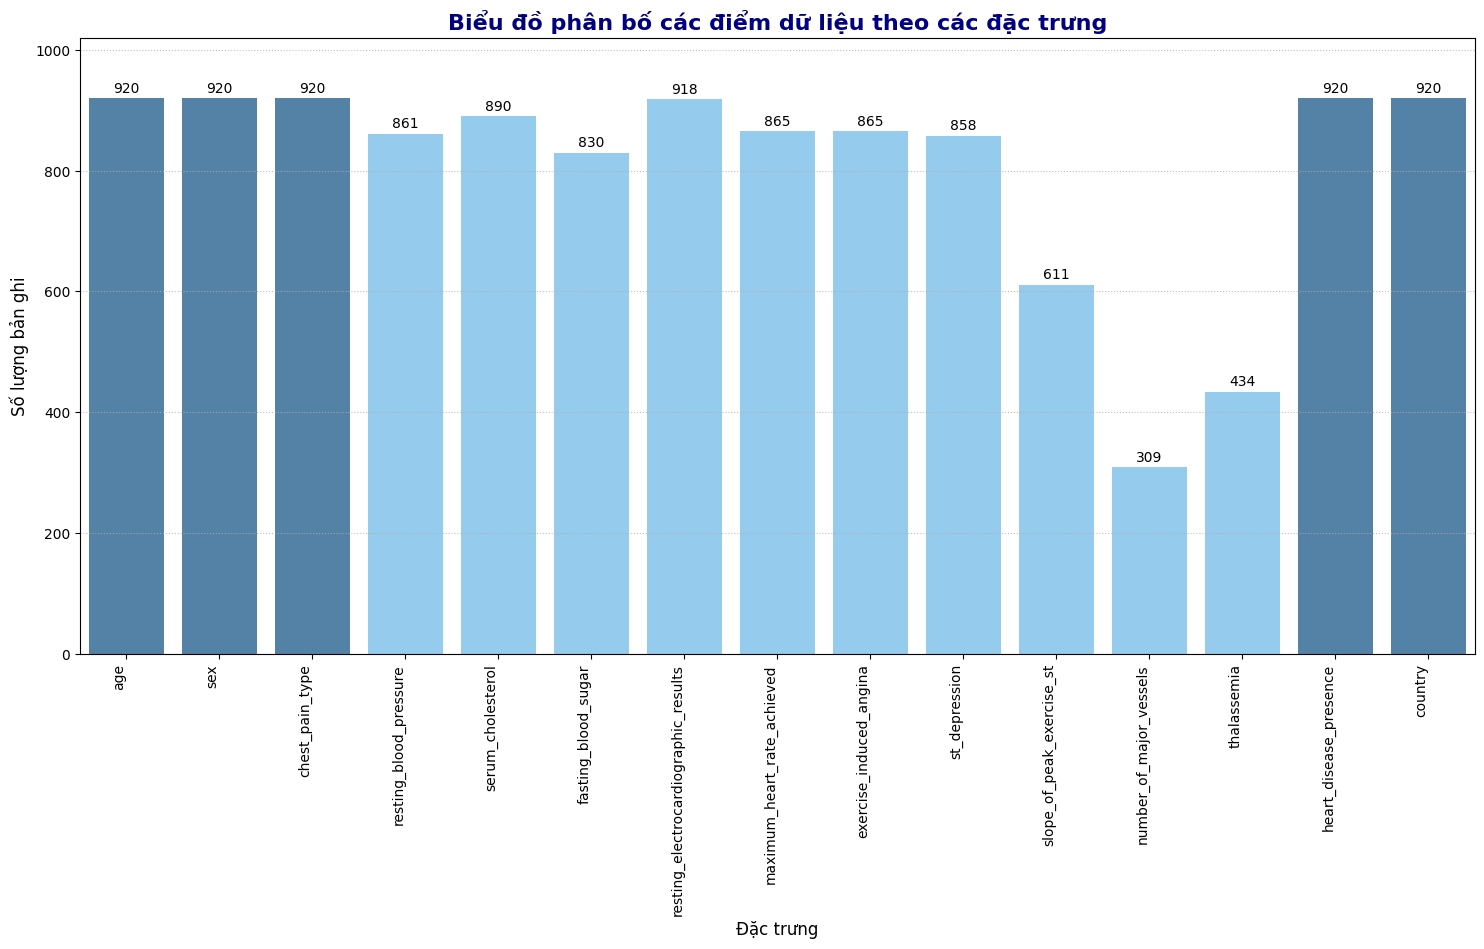

In [39]:
num_of_record = df.shape[0]
non_missing_counts = df.notna().sum()

plt.figure(figsize=(18, 8))
colors = ['steelblue' if value == num_of_record else 'lightskyblue' for value in non_missing_counts.values]

sns.barplot(x=non_missing_counts.index, y=non_missing_counts.values, palette=colors)

for index, value in enumerate(non_missing_counts.values):
    plt.text(index, value + 5, str(value), ha='center', va='bottom', fontsize=10)

plt.title("Biểu đồ phân bố các điểm dữ liệu theo các đặc trưng", fontsize=16, weight='bold', color="navy")
plt.xlabel("Đặc trưng", fontsize=12)
plt.ylabel("Số lượng bản ghi", fontsize=12)
plt.xticks(rotation=90, ha='right')
plt.ylim(0, df.shape[0] + 100)

plt.grid(axis='y', linestyle=':', alpha=0.8)
plt.show()

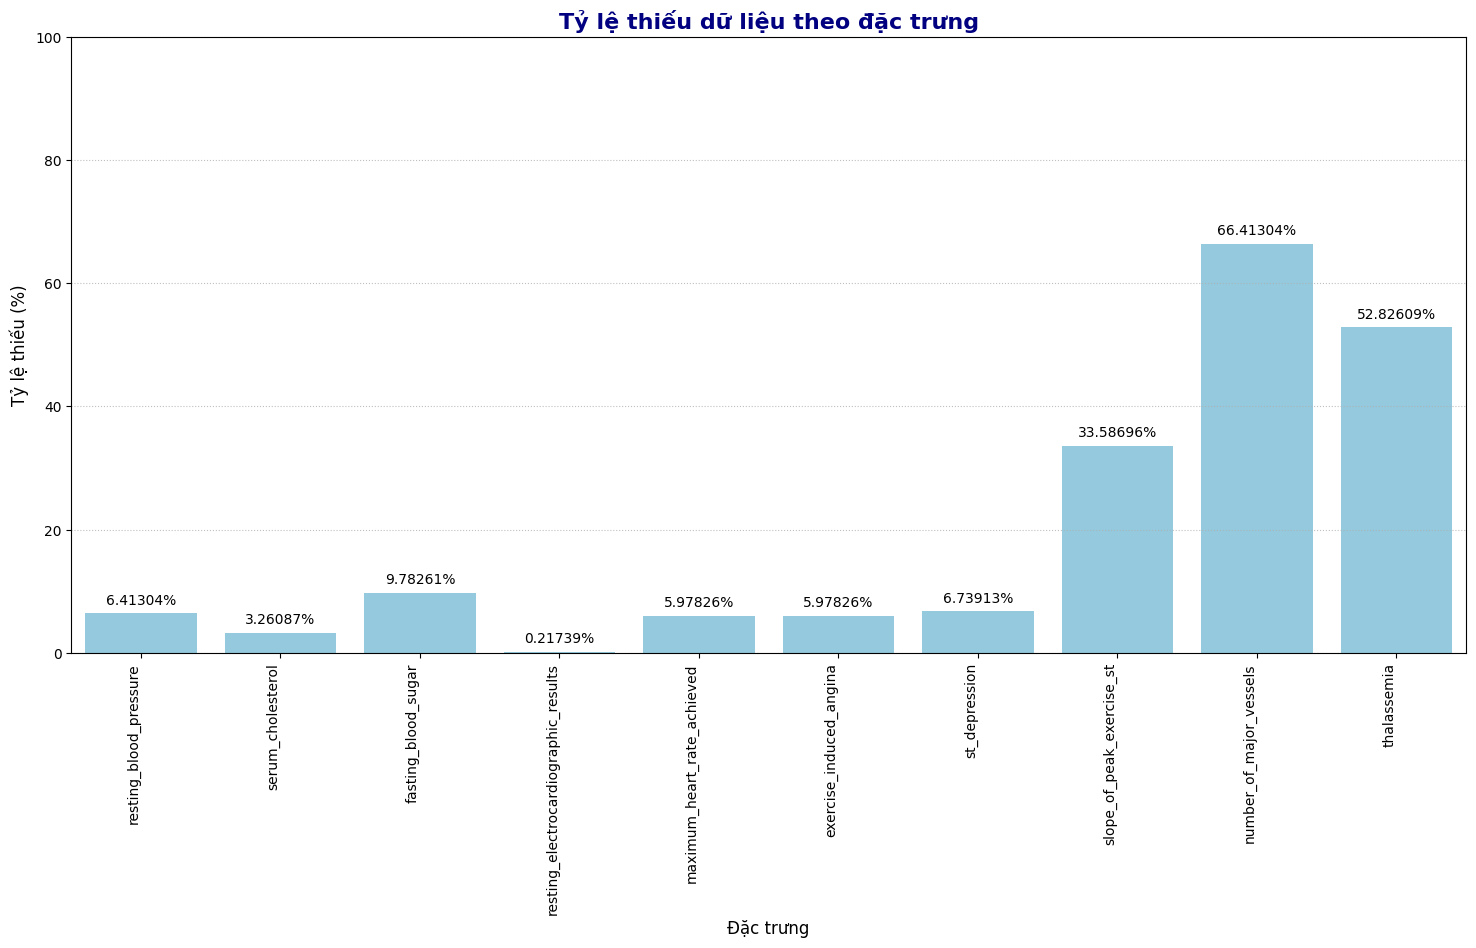

In [40]:
missing_counts = df.isna().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_percentage = (missing_counts / df.shape[0]) * 100


plt.figure(figsize=(18, 8))
sns.barplot(x=missing_counts.index, y=missing_percentage, color='skyblue')

for index, value in enumerate(missing_percentage):
    plt.text(index, value + 1, f"{value:.5f}%", ha='center', va='bottom', fontsize=10)

plt.title("Tỷ lệ thiếu dữ liệu theo đặc trưng", fontsize=16, weight='bold', color="navy")
plt.xlabel("Đặc trưng", fontsize=12)
plt.ylabel("Tỷ lệ thiếu (%)", fontsize=12)
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 100)

plt.grid(axis='y', linestyle=':', alpha=0.8)
plt.show()


**Nhận xét:**

- **5 biến không có giá trị thiếu** gồm: `age`, `sex`, `chest_pain_type`, `heart_disease_presence`, và `country`.
- **Một số biến có tỷ lệ thiếu thấp** (< 10%) như: `resting_blood_pressure`, `serum_cholesterol`, `fasting_blood_sugar`, ` resting_electrocardiographic_results`, `maximum_heart_rate_achieved`, `exercise_induced_angina`, `st_depression`. 
- **Ba biến có tỷ lệ thiếu rất cao**:
  - `number_of_major_vessels` thiếu **66.41%**
  - `thalassemia` thiếu **52.83%**
  - `slope_of_peak_exercise_st` thiếu **33.59%**

**Cách xử lý:**  
Để xử lý các giá trị bị thiếu trong tập dữ liệu, chúng tôi áp dụng hai phương pháp tùy theo loại biến:

- Đối với các **biến định lượng** (số thực, ví dụ: `resting_blood_pressure`, `serum_cholesterol`, `st_depression`, v.v.), chúng tôi sử dụng **giá trị trung bình (mean)** của từng biến để điền vào các ô bị thiếu nhằm giữ nguyên phân bố tổng thể của dữ liệu.
- Đối với các **biến định tính** (các biến phân loại, ví dụ: `thalassemia`, `slope_of_peak_exercise_st`, `number_of_major_vessels`), chúng tôi điền bằng **giá trị xuất hiện nhiều nhất (mode)** để đảm bảo tính đại diện cho phần lớn mẫu quan sát.

Phương pháp này giúp giữ lại toàn bộ dữ liệu, hạn chế mất mát thông tin trong quá trình phân tích.

In [41]:
discrete_columns = [
    "sex",
    "chest_pain_type",
    "fasting_blood_sugar",
    "resting_electrocardiographic_results",
    "exercise_induced_angina",
    "slope_of_peak_exercise_st",
    "number_of_major_vessels",
    "thalassemia",
    "heart_disease_presence"
]

continuous_columns = [
    "age",
    "resting_blood_pressure",
    "serum_cholesterol",
    "maximum_heart_rate_achieved",
    "st_depression"
]


In [42]:
for col in continuous_columns:
    mean_value = df[col].mean()
    df[col].fillna(mean_value, inplace=True)

for col in discrete_columns:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)

df.isna().sum()

age                                     0
sex                                     0
chest_pain_type                         0
resting_blood_pressure                  0
serum_cholesterol                       0
fasting_blood_sugar                     0
resting_electrocardiographic_results    0
maximum_heart_rate_achieved             0
exercise_induced_angina                 0
st_depression                           0
slope_of_peak_exercise_st               0
number_of_major_vessels                 0
thalassemia                             0
heart_disease_presence                  0
country                                 0
dtype: int64

### Xử lý dữ liệu trùng lặp

In [43]:
duplicates = df[df.duplicated()]
print("Số dòng bị trùng lặp hoàn toàn:", duplicates.shape[0])

Số dòng bị trùng lặp hoàn toàn: 2


**Cách xử lý:** Trong quá trình kiểm tra chất lượng dữ liệu, chúng tôi phát hiện có 2 dòng trùng lặp hoàn toàn trong tập dữ liệu. Việc giữ lại các dòng này có thể gây sai lệch trong phân tích thống kê và huấn luyện mô hình. Do đó, chúng tôi đã loại bỏ các dòng trùng lặp để đảm bảo tính toàn vẹn và chính xác của dữ liệu trước khi tiến hành các bước phân tích tiếp theo.

In [44]:
df = df.drop_duplicates()
duplicates = df[df.duplicated()]
print("Số dòng bị trùng lặp hoàn toàn:", duplicates.shape[0])

Số dòng bị trùng lặp hoàn toàn: 0


### Thông tin chung sau khi xử lý missing và duplicated

In [45]:
summary = {
    "Thông tin": [
        "Số lượng bản ghi (dòng)",
        "Số lượng biến (cột)",
        "Số dòng bị trùng lặp hoàn toàn",
        "Tổng số giá trị bị thiếu (missing values)"
    ],
    "Giá trị": [
        len(df),
        df.shape[1],
        df.duplicated().sum(),
        df.isnull().sum().sum()  # Tổng số ô bị missing
    ]
}

summary_df = pd.DataFrame(summary)

print("\nBẢNG TÓM TẮT THÔNG TIN DỮ LIỆU")
print(tabulate(summary_df, headers='keys', tablefmt='fancy_grid', showindex=False))



BẢNG TÓM TẮT THÔNG TIN DỮ LIỆU
╒═══════════════════════════════════════════╤═══════════╕
│ Thông tin                                 │   Giá trị │
╞═══════════════════════════════════════════╪═══════════╡
│ Số lượng bản ghi (dòng)                   │       918 │
├───────────────────────────────────────────┼───────────┤
│ Số lượng biến (cột)                       │        15 │
├───────────────────────────────────────────┼───────────┤
│ Số dòng bị trùng lặp hoàn toàn            │         0 │
├───────────────────────────────────────────┼───────────┤
│ Tổng số giá trị bị thiếu (missing values) │         0 │
╘═══════════════════════════════════════════╧═══════════╛


In [46]:
column_info = pd.DataFrame({
    "Tên cột": df.columns,
    "Kiểu dữ liệu": df.dtypes.values,
    "Số giá trị không null": df.notnull().sum().values,
    "Số giá trị null": df.isnull().sum().values,
    "Tỷ lệ thiếu (%)": (df.isnull().sum().values / len(df) * 100).round(2)
})

print("\nBẢNG CHI TIẾT CÁC BIẾN TRONG TẬP DỮ LIỆU")
print(tabulate(column_info, headers='keys', tablefmt='fancy_grid', showindex=False))


BẢNG CHI TIẾT CÁC BIẾN TRONG TẬP DỮ LIỆU
╒══════════════════════════════════════╤════════════════╤═════════════════════════╤═══════════════════╤═══════════════════╕
│ Tên cột                              │ Kiểu dữ liệu   │   Số giá trị không null │   Số giá trị null │   Tỷ lệ thiếu (%) │
╞══════════════════════════════════════╪════════════════╪═════════════════════════╪═══════════════════╪═══════════════════╡
│ age                                  │ float64        │                     918 │                 0 │                 0 │
├──────────────────────────────────────┼────────────────┼─────────────────────────┼───────────────────┼───────────────────┤
│ sex                                  │ float64        │                     918 │                 0 │                 0 │
├──────────────────────────────────────┼────────────────┼─────────────────────────┼───────────────────┼───────────────────┤
│ chest_pain_type                      │ float64        │                     918 │       

## Phân tích thống kê mô tả

In [47]:
df[continuous_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.00,77.0
resting_blood_pressure,918.0,132.137050,18.440088,0.0,120.00,130.0,140.00,200.0
serum_cholesterol,918.0,199.108693,109.074413,0.0,177.25,221.0,267.00,603.0
maximum_heart_rate_achieved,918.0,137.542496,25.146684,60.0,120.00,138.0,155.75,202.0
st_depression,918.0,0.880702,1.054122,-2.6,0.00,0.8,1.50,6.2


### Dữ liệu định lượng

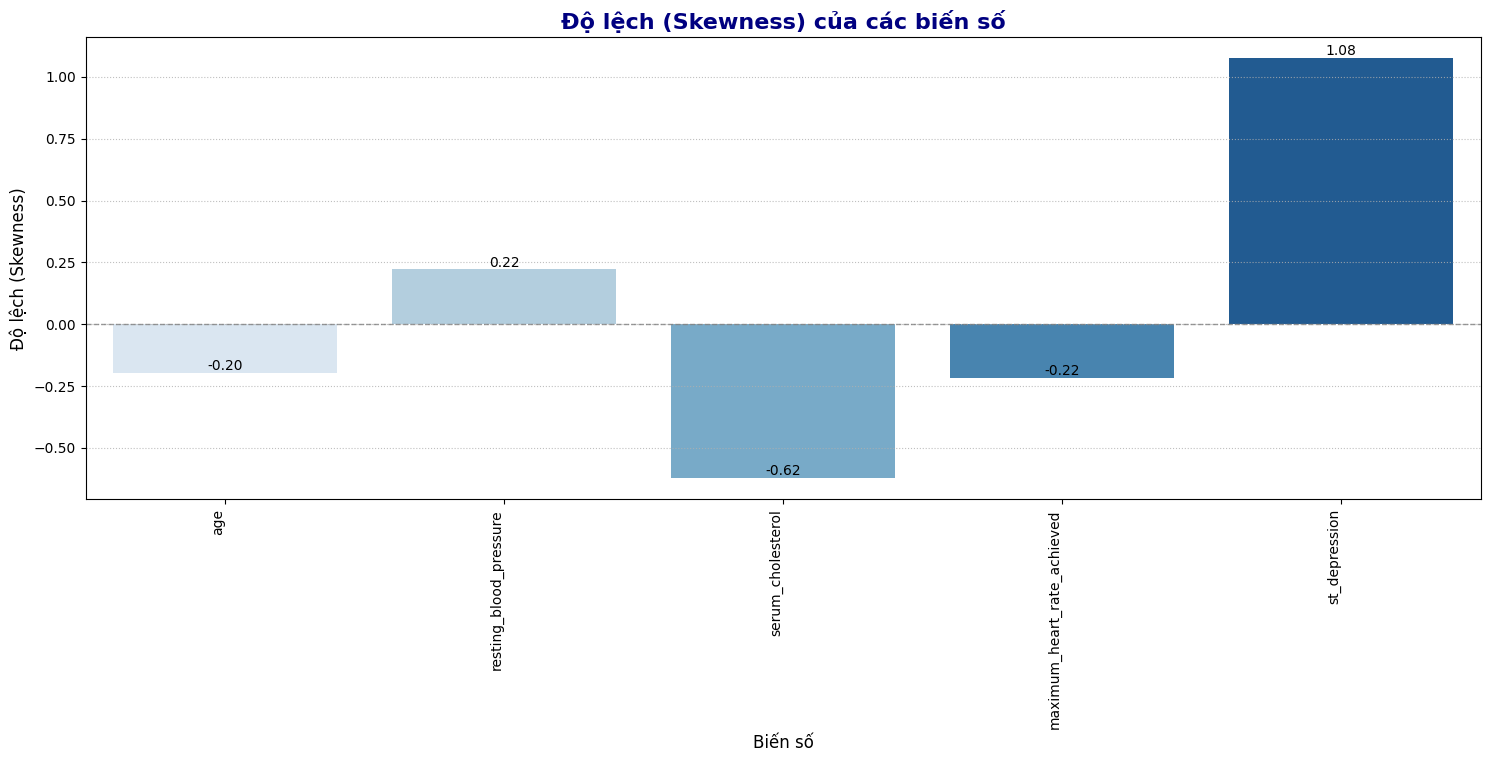

In [48]:
## Sử dụng countplot để coi độ lệch của các biến định lượng
skewness = df[continuous_columns].skew()

plt.figure(figsize=(18, 6))
sns.barplot(x=skewness.index, y=skewness.values, palette="Blues")
for index, value in enumerate(skewness.values):
    plt.text(index, value, f"{value:.2f}", ha='center', va='bottom', fontsize=10)
plt.title("Độ lệch (Skewness) của các biến số", fontsize=16, weight='bold', color="navy")
plt.xlabel("Biến số", fontsize=12)
plt.ylabel("Độ lệch (Skewness)", fontsize=12)
plt.xticks(ha='right', rotation = 90)
plt.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.8)
plt.grid(axis='y', linestyle=':', alpha=0.8)
plt.show()


**Phân tích:** Biểu đồ trên thể hiện độ lệch (skewness) của các biến định lượng trong tập dữ liệu. Kết quả cho thấy hầu hết các biến có độ lệch gần 0, phản ánh phân phối dữ liệu tương đối đối xứng. Tuy nhiên, biến st_depression có độ lệch dương khá lớn (1.08), cho thấy phân phối lệch phải — nghĩa là có nhiều giá trị nhỏ và một số ít giá trị lớn bất thường. Ngược lại, serum_cholesterol có độ lệch âm (-0.62), thể hiện phân phối lệch trái. Các biến còn lại như age, resting_blood_pressure, và maximum_heart_rate_achieved có độ lệch nhỏ, gần với phân phối chuẩn.

**Lý do sử dụng:** Việc phân tích skewness giúp đánh giá mức độ đối xứng của phân phối dữ liệu, từ đó quyết định có cần biến đổi dữ liệu (log, Box-Cox...) để cải thiện hiệu suất mô hình hoặc làm cho phân phối gần chuẩn hơn. Các biến có skewness lớn (>|1|) thường cần được xử lý trước khi đưa vào mô hình học máy.


---

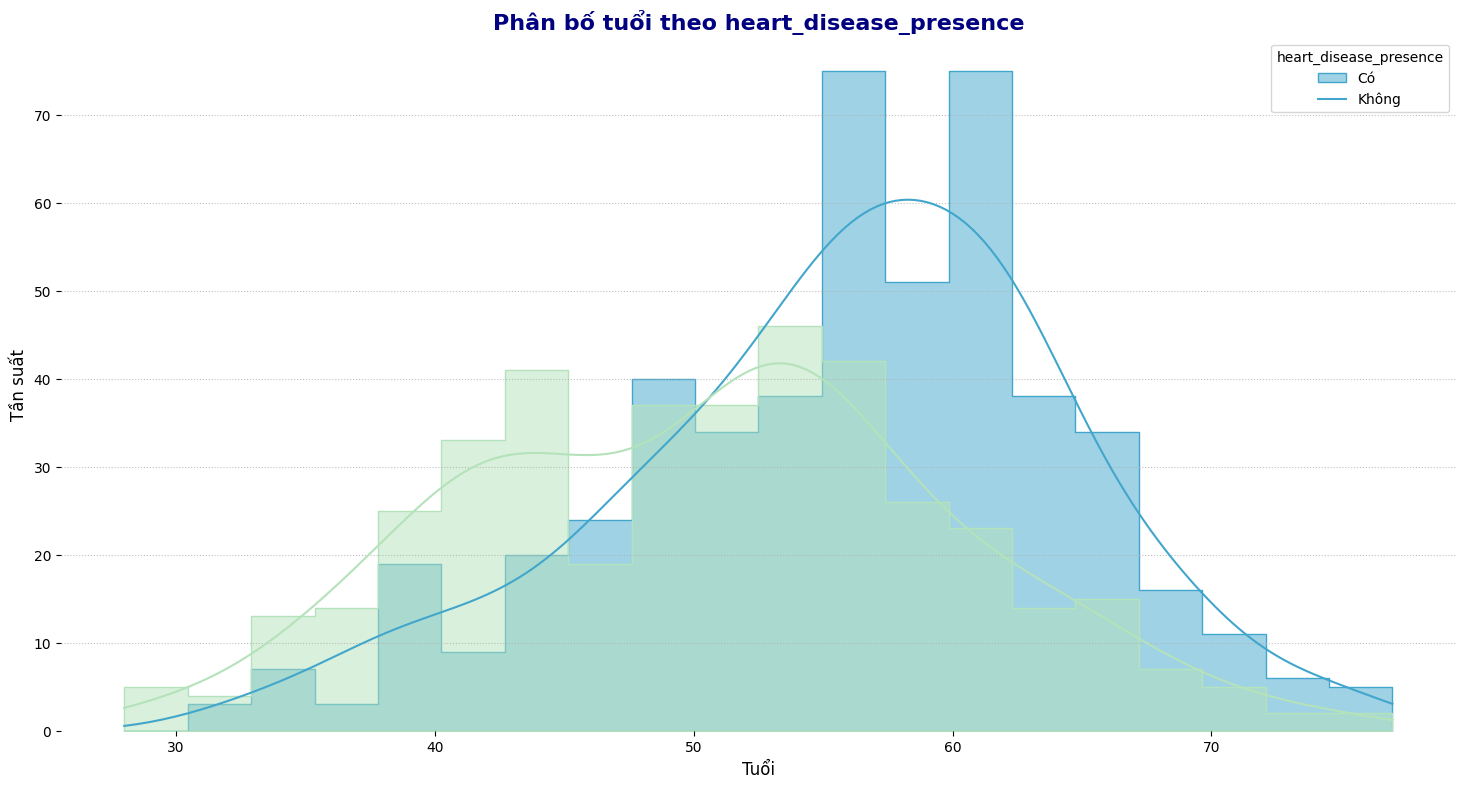

In [49]:
plt.figure(figsize=(18, 9))
sns.histplot(data=df, x='age', hue='heart_disease_presence', kde=True, palette='GnBu', element='step', bins=20, alpha=0.5)
plt.title("Phân bố tuổi theo heart_disease_presence", fontsize=16, weight='bold', color="navy")
plt.xlabel("Tuổi", fontsize=12)
plt.ylabel("Tần suất", fontsize=12)
plt.grid(axis='y', linestyle=':', alpha=0.8)
plt.legend(title="heart_disease_presence", labels=["Có", "Không"], loc='upper right')


sns.despine(left=True, bottom=True)
plt.show()

**Phân tích:** Biểu đồ thể hiện phân bố độ tuổi của bệnh nhân theo hai nhóm: có bệnh tim và không có bệnh tim. Có thể quan sát thấy rằng:

- Nhóm không mắc bệnh tim phân bố rộng hơn, tập trung nhiều ở độ tuổi khoảng 40–55, giảm dần sau đó.

- Trong khi đó, nhóm có bệnh tim có xu hướng tập trung ở độ tuổi từ 55–65, với đỉnh rõ rệt ở giai đoạn này.

- Phân bố của nhóm bệnh tim có dạng chuông lệch phải nhẹ, cho thấy bệnh tim phổ biến hơn ở người lớn tuổi.

**Lý do sử dụng:** 
Biểu đồ phân bố được sử dụng nhằm so sánh trực quan đặc điểm của biến định lượng age giữa các nhóm mục tiêu. Đây là cách hiệu quả để nhận diện mối liên hệ tiềm năng giữa độ tuổi và nguy cơ mắc bệnh tim.

---

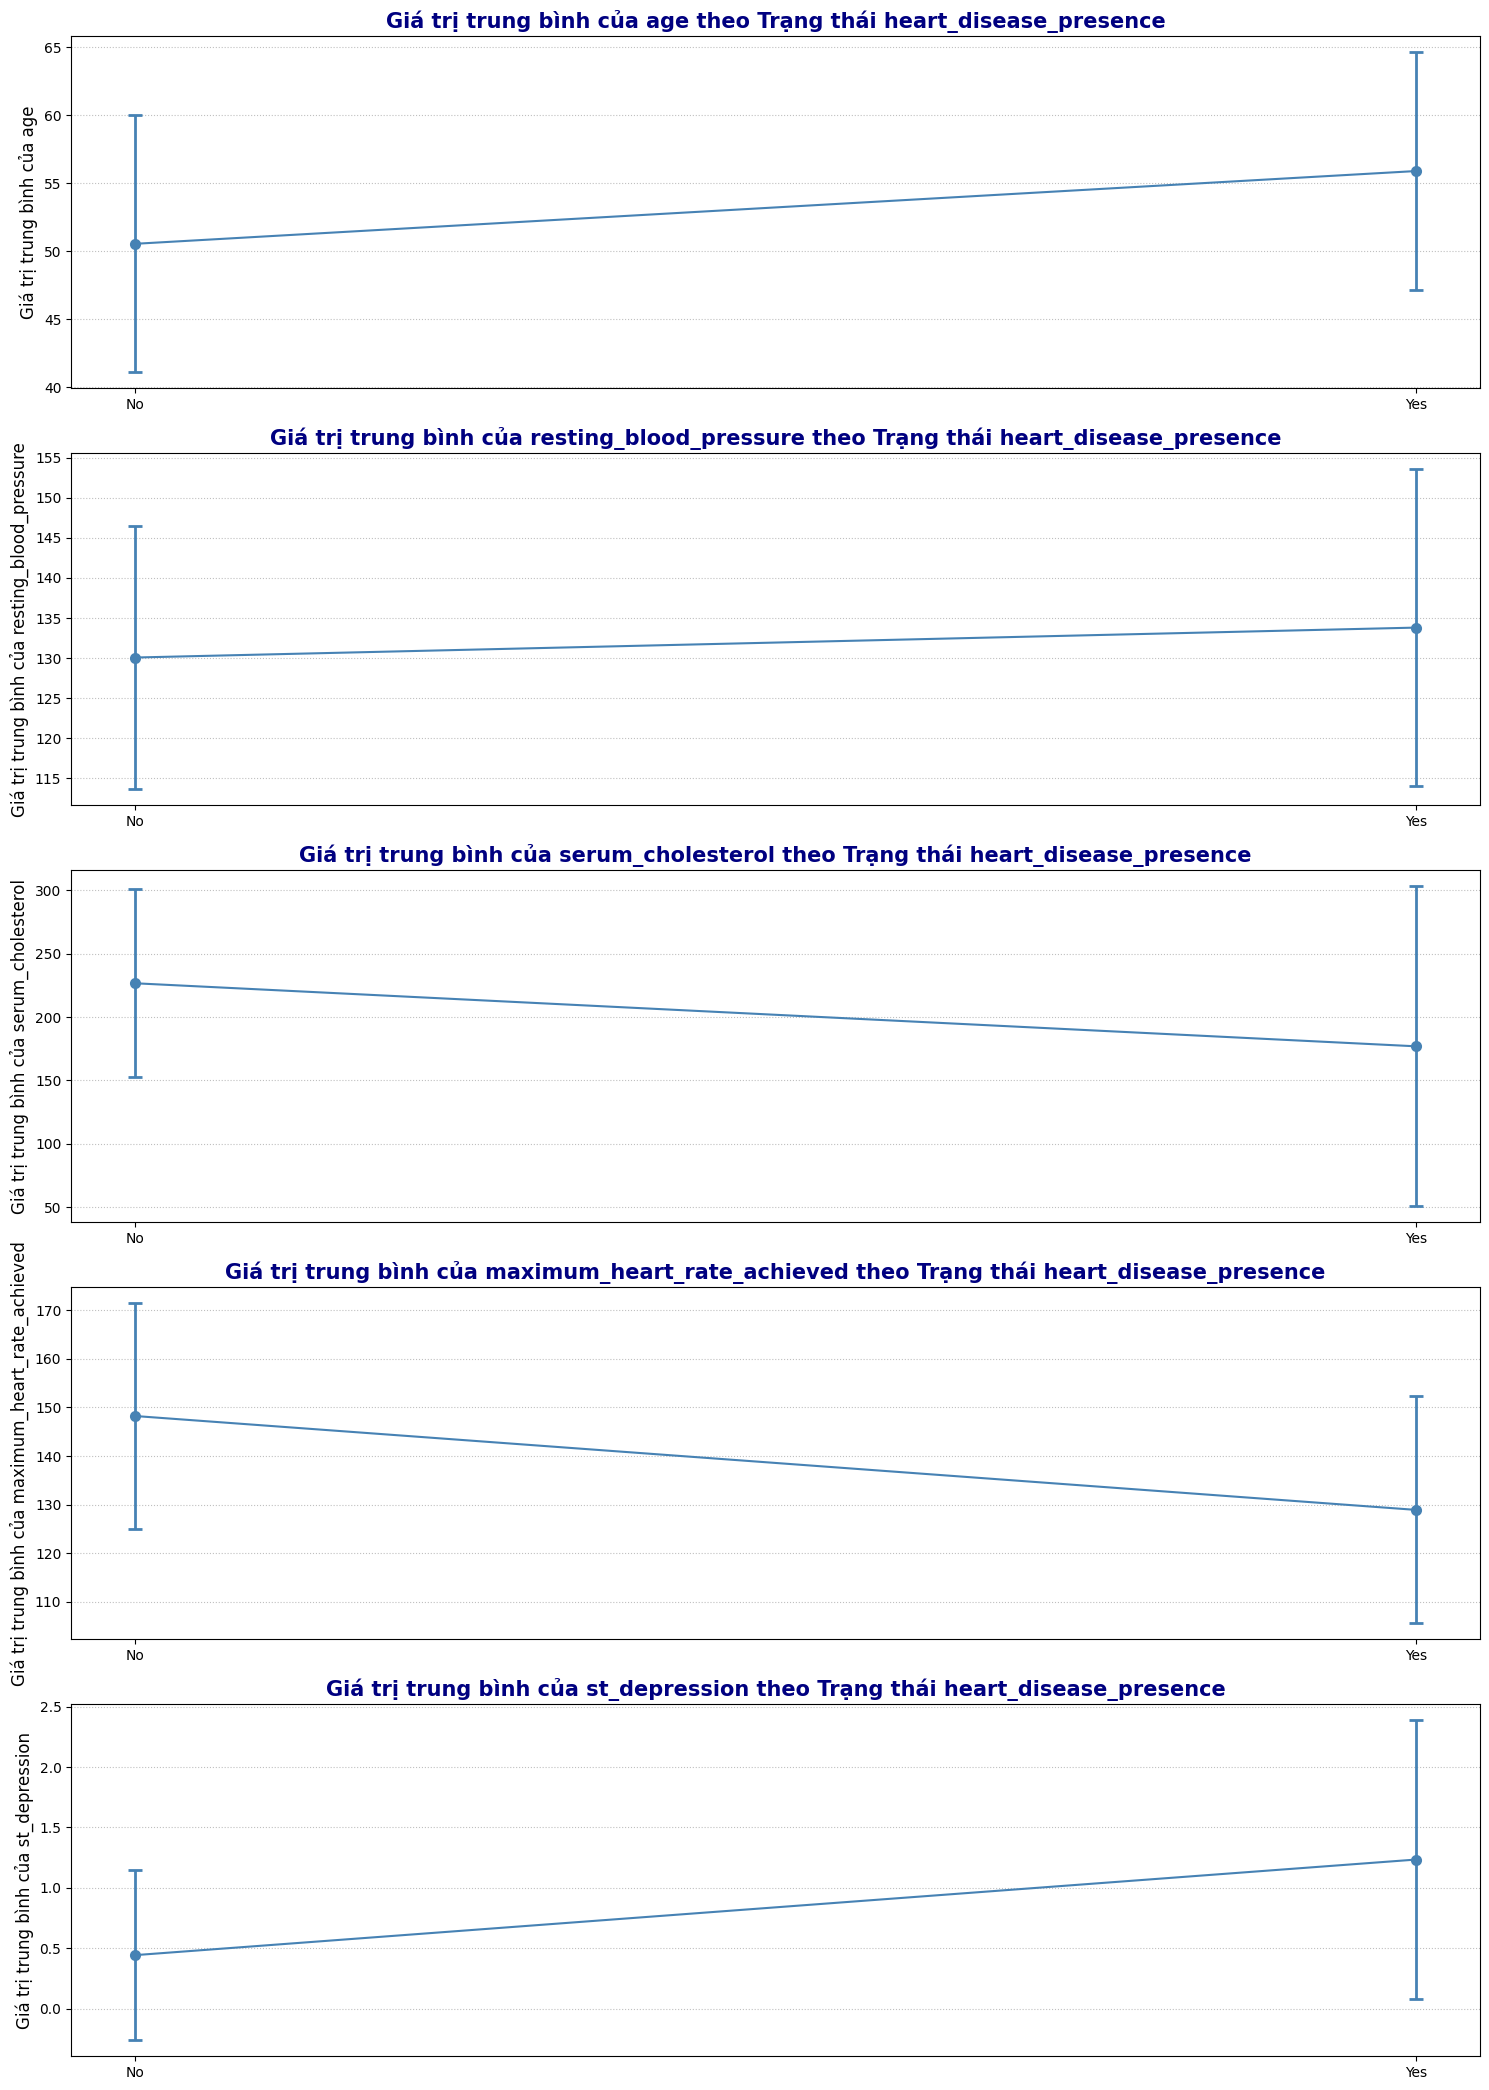

In [50]:
plt.figure(figsize=(15, 21))
for i, col in enumerate(continuous_columns, 1):
    mean_values = df.groupby('heart_disease_presence')[col].mean()
    std_values = df.groupby('heart_disease_presence')[col].std()
    

    plt.subplot(len(continuous_columns), 1, i)
    plt.errorbar(mean_values.index, mean_values, yerr=std_values, fmt='-o', color='steelblue', capsize=5, elinewidth=2, markeredgewidth=2)
    plt.title(f"Giá trị trung bình của {col} theo Trạng thái heart_disease_presence", fontsize=15, fontweight='bold', color="navy")
    plt.xlabel("", fontsize=12)
    plt.ylabel(f"Giá trị trung bình của {col}", fontsize=12)
    plt.xticks([0, 1], labels=['No', 'Yes'])
    plt.grid(axis='y', linestyle=':', alpha=0.8)

plt.tight_layout()
plt.show()

**Phân tích:** Biểu đồ thể hiện sự thay đổi giá trị trung bình của các biến định lượng theo tình trạng bệnh tim (heart_disease_presence). Kết quả cho thấy:

- (age): Nhóm có bệnh tim có độ tuổi trung bình cao hơn rõ rệt so với nhóm không mắc bệnh, cho thấy tuổi tác là yếu tố nguy cơ.

- (resting_blood_pressure) và mức độ trầm cảm ST (st_depression) đều có xu hướng tăng ở nhóm bệnh tim.

- Ngược lại, cholesterol (serum_cholesterol) và nhịp tim tối đa đạt được (maximum_heart_rate_achieved) lại giảm ở nhóm có bệnh tim, đặc biệt là nhịp tim tối đa có độ chênh khá lớn.


**Lý do sử dụng:** 
Biểu đồ đường với giá trị trung bình và khoảng tin cậy (error bars) được sử dụng nhằm trực quan hóa sự khác biệt giữa các nhóm trong biến mục tiêu. Trong bối cảnh phân tích dữ liệu, việc quan sát và so sánh giá trị trung bình của các biến định lượng theo trạng thái bệnh tim giúp hiểu rõ đặc điểm phân bố của từng nhóm, đồng thời phát hiện các xu hướng nổi bật hoặc bất thường. Đây là công cụ hữu ích để đặt ra giả thuyết phân tích, kiểm chứng mối liên hệ giữa các yếu tố sức khỏe (như huyết áp, nhịp tim, cholesterol...) với tình trạng bệnh, từ đó hỗ trợ hiểu sâu hơn bản chất dữ liệu và xây dựng nền tảng cho các phân tích tiếp theo.

---

### Dữ liệu định tính

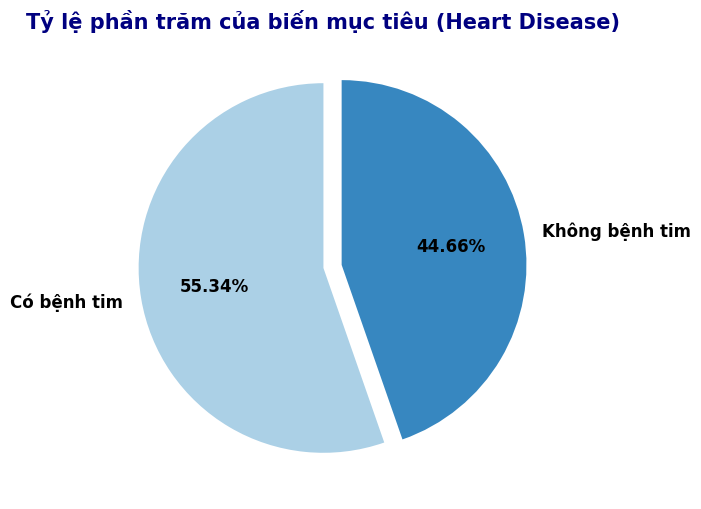

In [51]:

heart_counts = df['heart_disease_presence'].value_counts(normalize=True) * 100

labels = ["Không bệnh tim" if val == 0 else "Có bệnh tim" for val in heart_counts.index]


explode = [0.1 if val == heart_counts.min() else 0 for val in heart_counts]

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
plt.pie(
    heart_counts,
    labels=labels,
    autopct="%.2f%%",
    startangle=90,
    explode=explode,
    colors=sns.color_palette("Blues", len(heart_counts)),
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

plt.title("Tỷ lệ phần trăm của biến mục tiêu (Heart Disease)", fontsize=15, fontweight='bold', color="navy")
plt.show()


**Phân tích:** Biểu đồ tròn cho thấy tỷ lệ phân bố của biến mục tiêu heart_disease_presence, phản ánh tình trạng mắc bệnh tim trong tập dữ liệu. Cụ thể, khoảng 55.34% người trong tập dữ liệu được chẩn đoán có bệnh tim, trong khi 44.66% không mắc bệnh. Phân bố này khá cân bằng và không bị lệch quá nhiều về một phía, điều này thuận lợi cho việc phân tích thống kê so sánh giữa hai nhóm.

**Lý do sử dụng:** Biểu đồ tròn được sử dụng vì đây là cách đơn giản và trực quan để nhìn nhanh cơ cấu phân bố của biến mục tiêu. Việc nắm được tỷ lệ giữa các nhóm ngay từ đầu giúp định hình hướng phân tích: liệu dữ liệu có mất cân bằng không, nhóm nào chiếm ưu thế, và nên chú ý điều gì trong các bước tiếp theo. Đây là bước quan trọng để hiểu tổng quan dữ liệu trước khi đi sâu vào các phân tích chi tiết hơn.

----

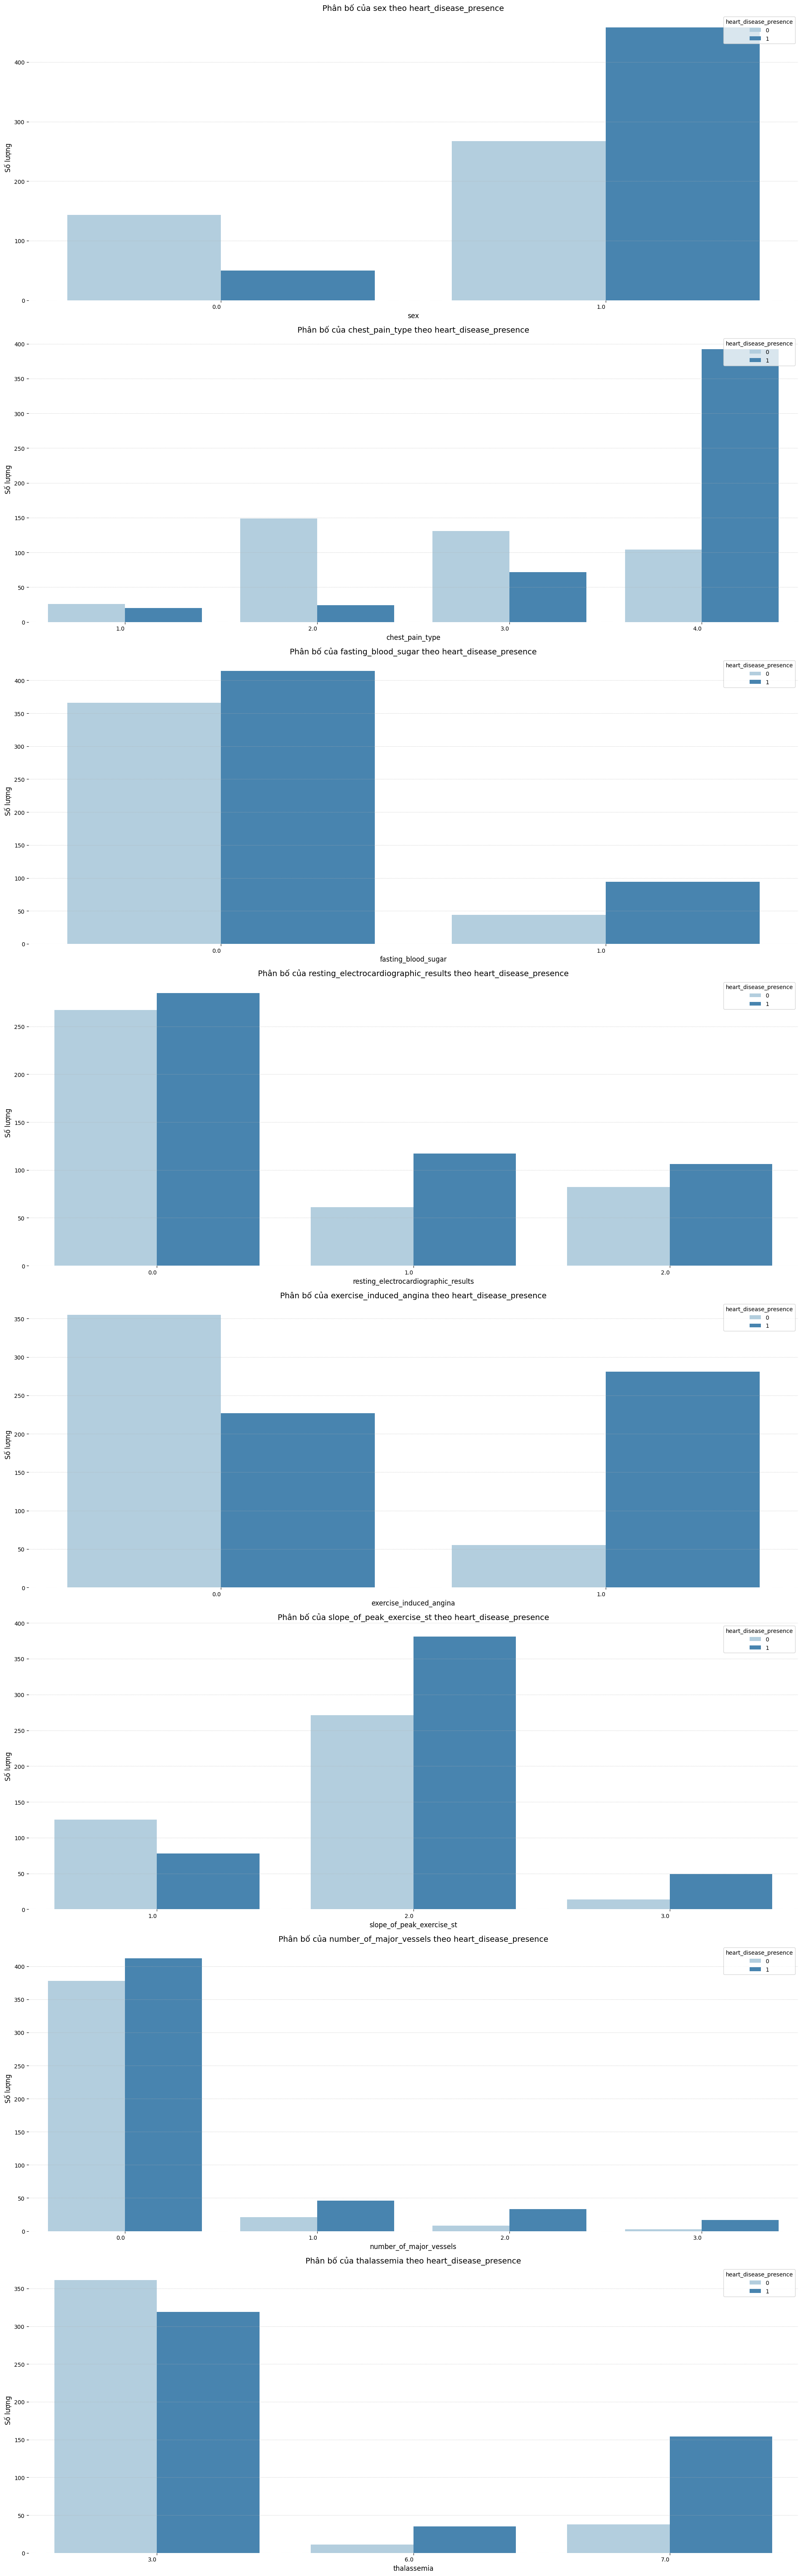

In [52]:
num_plots = len(discrete_columns) - 1 
plt.figure(figsize=(20, num_plots * 8))

for i, col in enumerate(discrete_columns, 1):
    if col == "heart_disease_presence":
        break
    plt.subplot(num_plots, 1, i)
    sns.countplot(data=df, x=col, hue='heart_disease_presence', palette='Blues')
    plt.title(f'Phân bố của {col} theo heart_disease_presence', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Số lượng', fontsize=12)
    plt.xticks(ha='right')
    plt.legend(title='heart_disease_presence', loc='upper right')
    plt.grid(axis='y', linestyle=':', alpha=0.8)
    plt.gca().patch.set_alpha(0)
    
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

**Phân tích:** Các biểu đồ trên thể hiện phân bố của các biến rời rạc theo tình trạng bệnh tim. Một số điểm nổi bật có thể quan sát được:

- Giới tính (sex): Tỷ lệ nam giới mắc bệnh tim cao hơn nữ giới đáng kể.

- Kiểu đau ngực (chest_pain_type): Nhóm "không có triệu chứng" (mã 4) chiếm tỷ lệ lớn trong nhóm có bệnh tim, trong khi các loại đau thắt ngực không điển hình phổ biến hơn ở nhóm không bệnh.

- Đường huyết lúc đói (fasting_blood_sugar): Phần lớn bệnh nhân thuộc cả hai nhóm đều không có đường huyết cao (>120 mg/dl), tuy nhiên số người có đường huyết cao lại nghiêng nhiều về nhóm mắc bệnh tim.

- Điện tâm đồ khi nghỉ (resting_electrocardiographic_results) và đau thắt ngực do gắng sức (exercise_induced_angina): Các biến này cũng thể hiện sự khác biệt giữa hai nhóm, đặc biệt là nhóm có kết quả điện tâm đồ bất thường hoặc xuất hiện đau thắt ngực khi gắng sức thường đi kèm tỷ lệ mắc bệnh cao hơn.

- Slope ST, số mạch máu chính tô màu (number_of_major_vessels), và thalassemia đều cho thấy những nhóm có đặc điểm bất thường hoặc cao hơn thường đi kèm tỷ lệ mắc bệnh tim nhiều hơn.

**Lý do sử dụng:**  Các biểu đồ cột được sử dụng để so sánh trực quan phân bố của các biến phân loại giữa hai nhóm bệnh tim và không bệnh tim. Đây là phương pháp hiệu quả trong phân tích dữ liệu để phát hiện ra các đặc điểm nổi bật, mối liên hệ tiềm năng hoặc xu hướng khác biệt giữa các nhóm. Từ đó, giúp người phân tích có cái nhìn tổng thể về cấu trúc dữ liệu, định hình các giả thuyết và đưa ra nhận định mang tính khám phá ban đầu trước khi thực hiện các phân tích định lượng sâu hơn.


---

## Phát hiện dữ liệu ngoại lai

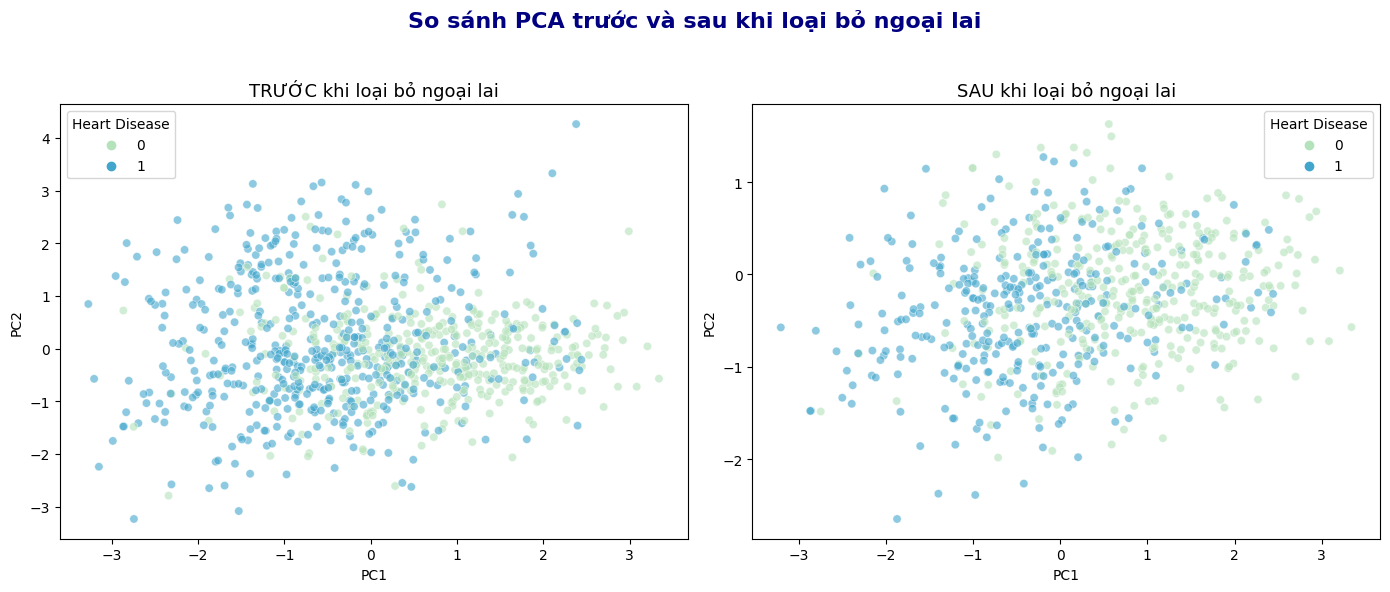

In [53]:
df_cont = df[continuous_columns]


Q1 = df_cont.quantile(0.25)
Q3 = df_cont.quantile(0.75)
IQR = Q3 - Q1

non_outliers_mask = ~((df_cont < (Q1 - 1.5 * IQR)) | (df_cont > (Q3 + 1.5 * IQR))).any(axis=1)

df_before = df.dropna()                         
df_after = df[non_outliers_mask].dropna()     

scaler = StandardScaler()
scaled_before = scaler.fit_transform(df_before[continuous_columns])
scaled_after = scaler.transform(df_after[continuous_columns])

pca = PCA(n_components=2)
pca_before = pca.fit_transform(scaled_before)
pca_after = pca.transform(scaled_after)


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_before[:, 0], y=pca_before[:, 1],
                hue=df_before['heart_disease_presence'],
                palette='GnBu', alpha=0.6)
plt.title("TRƯỚC khi loại bỏ ngoại lai", fontsize=13)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Heart Disease')


plt.subplot(1, 2, 2)
sns.scatterplot(x=pca_after[:, 0], y=pca_after[:, 1],
                hue=df_after['heart_disease_presence'],
                palette='GnBu', alpha=0.6)
plt.title("SAU khi loại bỏ ngoại lai", fontsize=13)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Heart Disease')

plt.suptitle("So sánh PCA trước và sau khi loại bỏ ngoại lai", fontsize=16, weight='bold', color='navy')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Nhận xét:** Sau khi loại bỏ ngoại lai bằng phương pháp IQR (hình bên phải), phân bố dữ liệu trở nên chặt chẽ và tập trung hơn quanh trung tâm cụm, đặc biệt là giảm số lượng điểm nằm xa cụm chính. Việc loại bỏ các giá trị cực đoan đã giúp làm sạch không gian dữ liệu, giúp việc phân tích trực quan trở nên rõ ràng hơn, đồng thời hỗ trợ các phân tích thống kê và mô hình hóa sau này trở nên ổn định và hiệu quả hơn.

Trong quá trình phân tích, chúng tôi phân biệt rõ giữa hai mục tiêu: khám phá dữ liệu (EDA) và xây dựng mô hình dự đoán. Cụ thể, ở bước khám phá insight, chúng tôi giữ lại các giá trị ngoại lai để phản ánh đúng phân bố tự nhiên và phát hiện các trường hợp đặc biệt trong dữ liệu. Ngược lại, khi xây dựng mô hình, chúng tôi loại bỏ outlier dựa trên các biến định lượng nhằm tăng tính ổn định, độ chính xác và giảm nhiễu cho mô hình học máy.

In [54]:
summary = {
    "Thông tin": [
        "Số lượng bản ghi (dòng)",
        "Số lượng biến (cột)",
        "Số dòng bị trùng lặp hoàn toàn",
        "Tổng số giá trị bị thiếu (missing values)"
    ],
    "Giá trị": [
        len(df_after),
        df_after.shape[1],
        df_after.duplicated().sum(),
        df_after.isnull().sum().sum()  
    ]
}

summary_df = pd.DataFrame(summary)

print("\nBẢNG TÓM TẮT THÔNG TIN DỮ LIỆU")
print(tabulate(summary_df, headers='keys', tablefmt='fancy_grid', showindex=False))



BẢNG TÓM TẮT THÔNG TIN DỮ LIỆU
╒═══════════════════════════════════════════╤═══════════╕
│ Thông tin                                 │   Giá trị │
╞═══════════════════════════════════════════╪═══════════╡
│ Số lượng bản ghi (dòng)                   │       701 │
├───────────────────────────────────────────┼───────────┤
│ Số lượng biến (cột)                       │        15 │
├───────────────────────────────────────────┼───────────┤
│ Số dòng bị trùng lặp hoàn toàn            │         0 │
├───────────────────────────────────────────┼───────────┤
│ Tổng số giá trị bị thiếu (missing values) │         0 │
╘═══════════════════════════════════════════╧═══════════╛


# Phân tích phân phối xác suất

In [55]:
age = df["age"]
resting_blood_pressure= df["resting_blood_pressure"]
maximum_heart_rate_achieved= df["maximum_heart_rate_achieved"]
st_depression= df["st_depression"]
serum_cholesterol= df["serum_cholesterol"]
# reading_scores = df["reading score"]
# writing_scores = df["writing score"]

In [56]:
from scipy.stats import normaltest
def check_normality(data, title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.histplot(data, kde=True, bins=5, color="steelblue", ax=axes[0])
    axes[0].set_title(f"Histogram & KDE của {title}")
    axes[0].set_xlabel(title)
    axes[0].set_ylabel("Tần suất")

    stats.probplot(data, dist="norm", plot=axes[1])
    axes[1].set_title(f"Q-Q Plot của {title}")
    
    plt.tight_layout()
    plt.show()

    stat, p = normaltest(data)
    print(f'D’Agostino-Pearson: Statistic={stat}, p-value={p}')


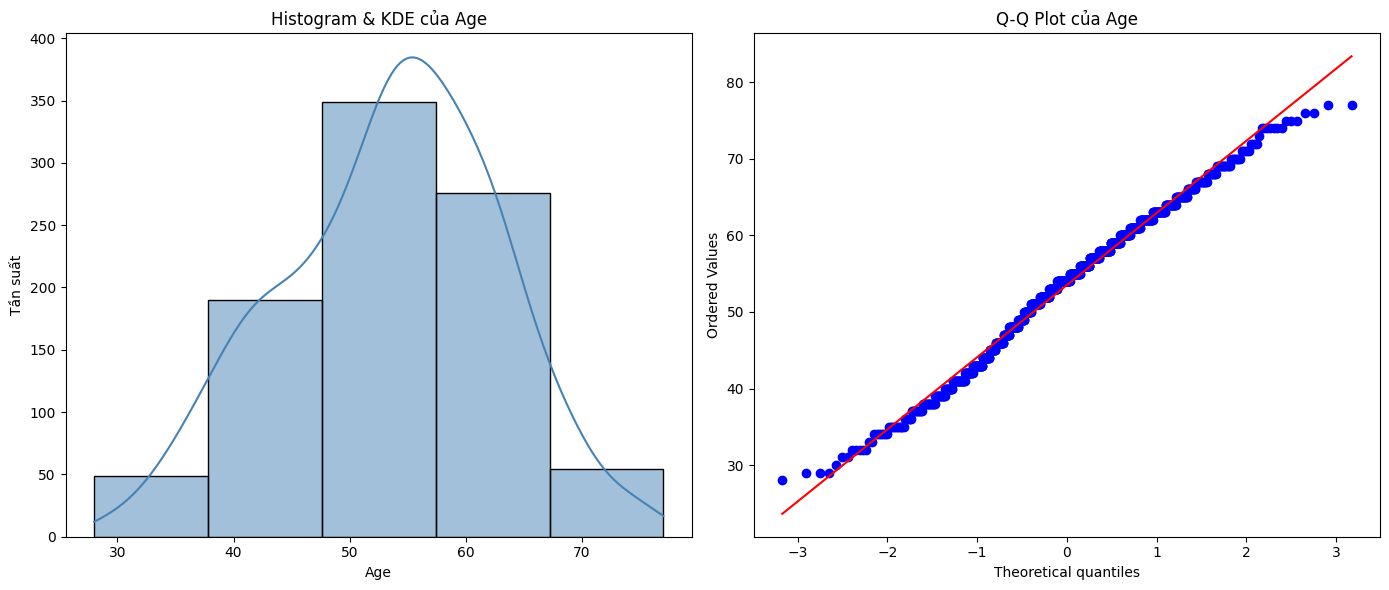

D’Agostino-Pearson: Statistic=14.387278957845886, p-value=0.0007513496172395633


In [57]:
check_normality(age, "Age")

**Nhận xét**: Dựa trên kiểm định D’Agostino-Pearson với statistic = 14.39 và p-value = 0.00075 (< 0.05), ta bác bỏ giả thuyết H0 và kết luận rằng biến Age không hoàn toàn tuân theo phân phối chuẩn. Tuy nhiên, biểu đồ histogram và KDE cho thấy phân phối có dạng chuông, khá đối xứng và mượt, chỉ hơi lệch phải nhẹ. Q-Q plot cũng xác nhận điều này khi phần lớn điểm nằm gần đường chuẩn, chỉ có đuôi bên phải hơi cong lên. Như vậy, dù dữ liệu Age gần chuẩn, kiểm định vẫn phát hiện sai lệch nhẹ ở phần đuôi – đây là mức sai lệch không quá nghiêm trọng và có thể chấp nhận được trong một số trường hợp phân tích.









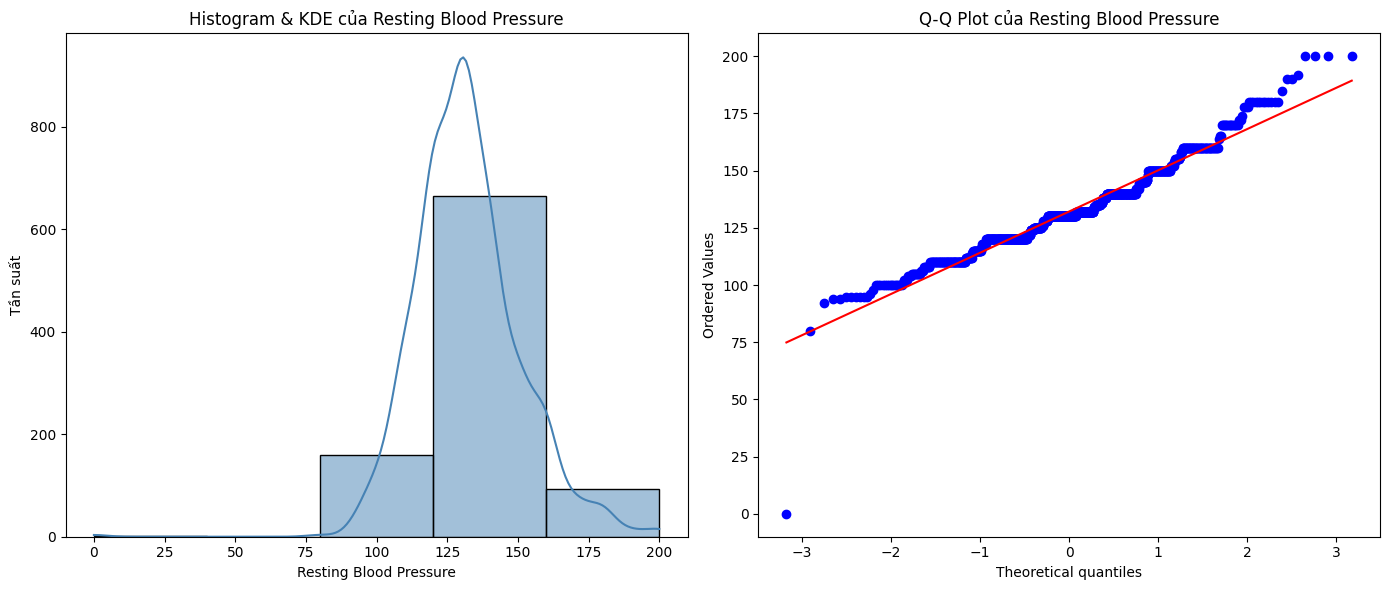

D’Agostino-Pearson: Statistic=84.96923420181992, p-value=3.541320449670711e-19


In [58]:
check_normality(resting_blood_pressure, "Resting Blood Pressure")

**Nhận xét:** Dựa trên kiểm định D’Agostino-Pearson với statistic = 84.97 và p-value ≈ 3.54e-19 (< 0.05), ta bác bỏ giả thuyết H0 và kết luận rằng biến Resting Blood Pressure không tuân theo phân phối chuẩn. Histogram và KDE cho thấy phân bố lệch phải rõ rệt, với đỉnh tập trung ở khoảng 125–135 và phần đuôi kéo dài về phía giá trị cao. Q-Q plot cũng xác nhận điều này khi các điểm ở đuôi bên phải nằm lệch lên trên, phản ánh sự xuất hiện của nhiều giá trị cao hơn kỳ vọng. Tất cả các biểu đồ và kiểm định đều nhất quán cho thấy Resting Blood Pressure lệch phải mạnh, và có thể cần xử lý như log-transform nếu sử dụng các phương pháp thống kê yêu cầu dữ liệu chuẩn.

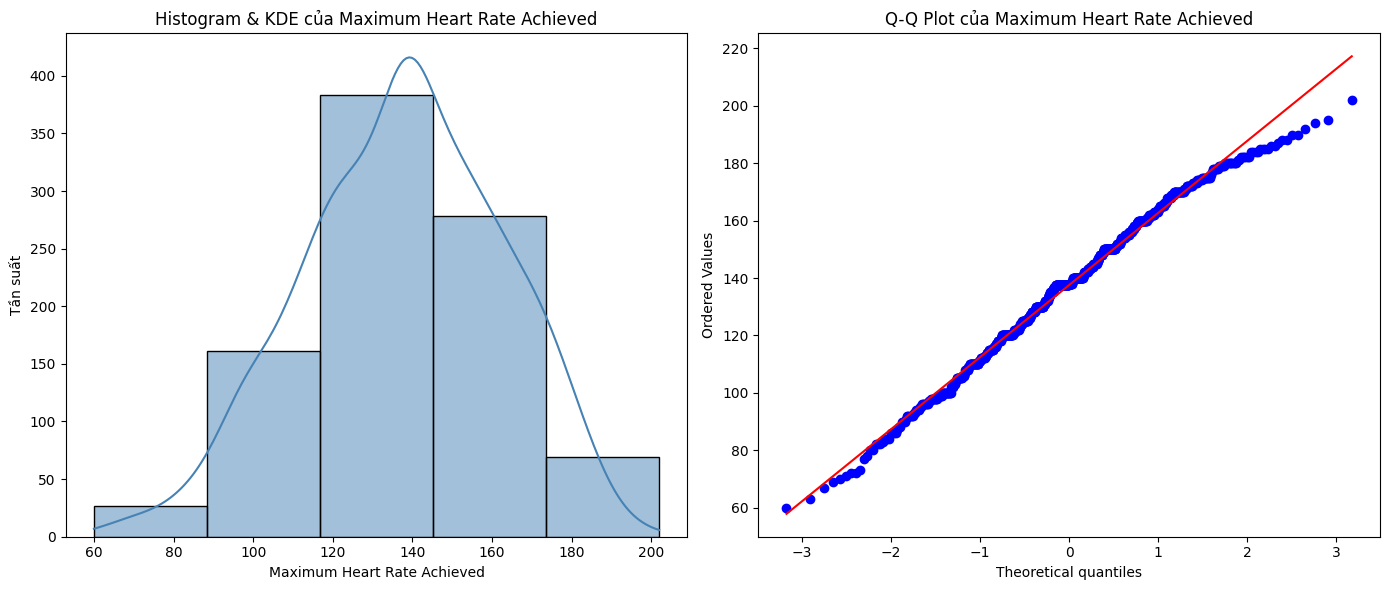

D’Agostino-Pearson: Statistic=12.429550118980778, p-value=0.001999666105738052


In [59]:
check_normality(maximum_heart_rate_achieved, "Maximum Heart Rate Achieved")

**Nhận xét:** Dựa trên kiểm định D’Agostino-Pearson với statistic = 12.43 và p-value = 0.00199 (< 0.05), ta bác bỏ giả thuyết H0 và kết luận rằng biến Maximum Heart Rate Achieved không hoàn toàn tuân theo phân phối chuẩn. Histogram và KDE cho thấy phân bố có dạng gần chuẩn, đỉnh nằm khoảng 130–140, tuy nhiên có dấu hiệu lệch phải nhẹ với phần đuôi bên phải dài và dày hơn. Q-Q plot cũng xác nhận điều này khi các điểm ở đuôi phải lệch khỏi đường chuẩn. Mặc dù sai lệch không nghiêm trọng, kiểm định vẫn phát hiện sự khác biệt có ý nghĩa thống kê. Do đó, có thể tạm xem dữ liệu gần chuẩn trong một số phân tích, nhưng nên cẩn trọng nếu dùng các mô hình nhạy với giả định chuẩn.

------------- 

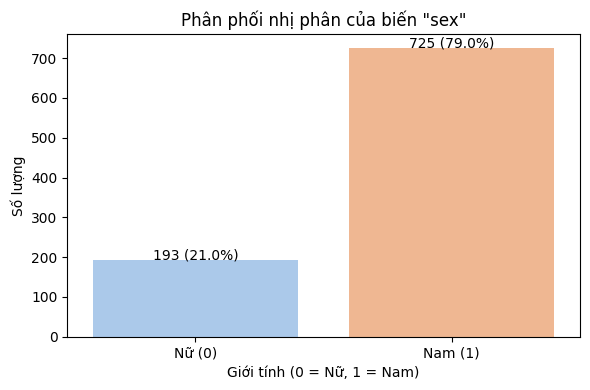

In [60]:
sex_counts = df['sex'].value_counts().sort_index()


plt.figure(figsize=(6, 4))
sns.barplot(x=sex_counts.index, y=sex_counts.values, palette='pastel')

plt.title('Phân phối nhị phân của biến "sex"')
plt.xlabel('Giới tính (0 = Nữ, 1 = Nam)')
plt.ylabel('Số lượng')
plt.xticks([0, 1], ['Nữ (0)', 'Nam (1)'])

total = sex_counts.sum()
for i, count in enumerate(sex_counts):
    plt.text(i, count + 2, f"{count} ({count/total:.1%})", ha='center')

plt.tight_layout()
plt.show()


**Nhận xét:** Biểu đồ trên cho thấy phân phối giới tính trong dữ liệu có sự mất cân bằng rõ rệt, với 79% là nam và chỉ 21% là nữ. Tỷ lệ nam cao gần gấp 4 lần nữ, cho thấy dữ liệu bị thiên lệch giới tính. Sự mất cân đối này cần được lưu ý, vì có thể ảnh hưởng đến tính đại diện và kết quả phân tích liên quan đến yếu tố giới.|

# Kiểm định giả thuyết

In [61]:
combined_df = df.copy()
combined_df["resting_blood_pressure"] = pd.to_numeric(combined_df["resting_blood_pressure"], errors="coerce")

male_bp = combined_df[combined_df["sex"] == 1]["resting_blood_pressure"].dropna()
female_bp = combined_df[combined_df["sex"] == 0]["resting_blood_pressure"].dropna()

t_stat, p_value = ttest_ind(male_bp, female_bp, equal_var=False)

print(f"T-statistic = {t_stat:.4f}")
print(f"P-value = {p_value:.4f}")

T-statistic = -0.0584
P-value = 0.9534


**Kết quả từ phân tích:**
- Kết quả kiểm định T-test cho thấy T-statistic = -0.0584 và P-value = 0.9534.
- Vì P-value > 0.05, chúng ta không bác bỏ giả thuyết H0, tức là không có sự khác biệt đáng kể về huyết áp trung bình giữa nam và nữ trong bộ dữ liệu này.
   
**Kết luận bổ sung:**
- Với p-value = 0.9534, xác suất để sự khác biệt chỉ là ngẫu nhiên là rất cao.
- Điều này cho thấy không có bằng chứng thống kê đủ mạnh để khẳng định sự khác biệt về huyết áp giữa bệnh nhân nam và nữ.


# Phân tích tương quan giữa các biến

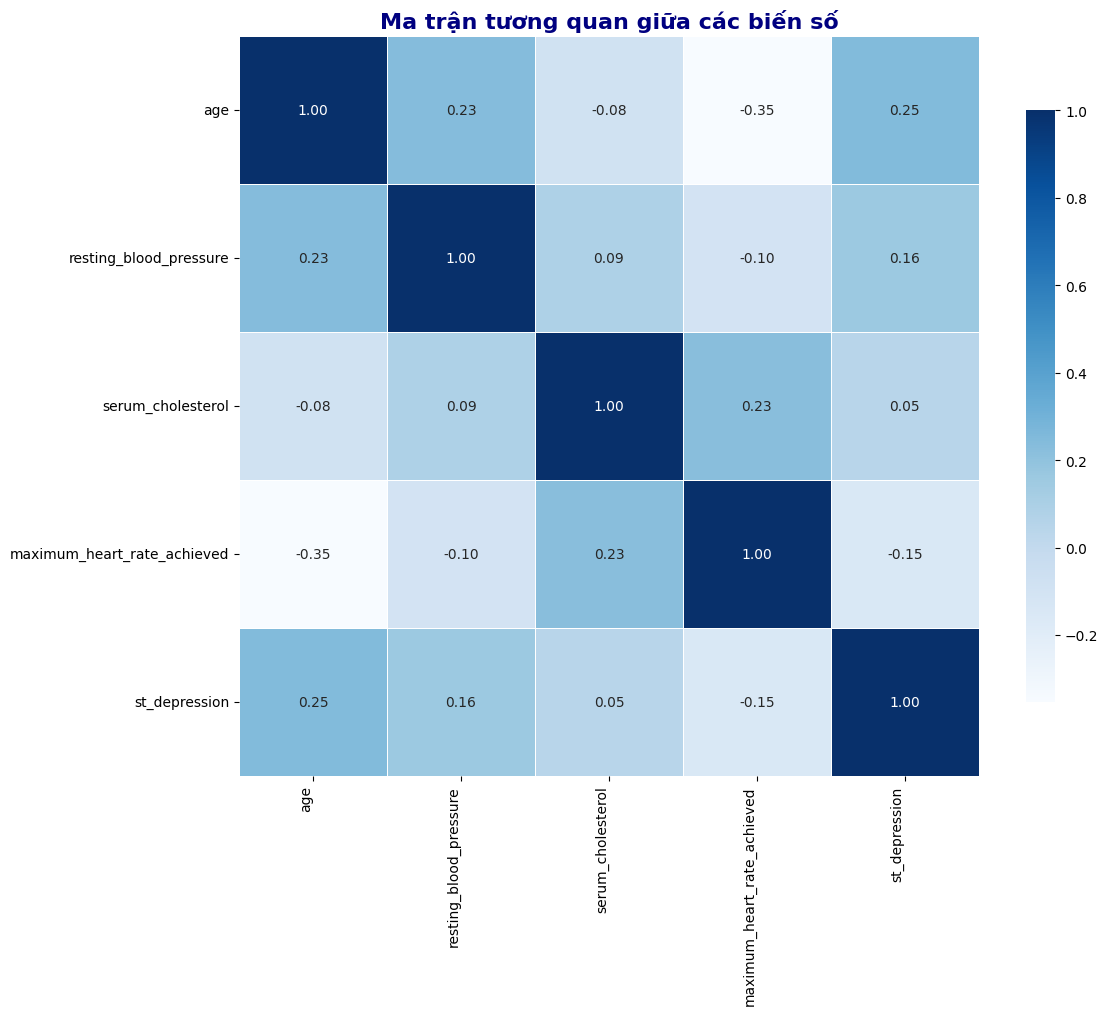

In [62]:
num_df = df[continuous_columns]
corr = num_df.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="Blues",              
    linewidths=0.5,
    square=True,
    cbar_kws={'shrink': 0.8}
)

plt.title("Ma trận tương quan giữa các biến số", fontsize=16, color='navy', weight='bold')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Nhận xét:**  
Ma trận tương quan cho thấy phần lớn các biến định lượng trong tập dữ liệu có mối tương quan ở mức thấp đến trung bình với nhau. Cụ thể, biến `age` có tương quan dương nhẹ với `st_depression` (0.25) và `resting_blood_pressure` (0.23), nhưng lại có tương quan âm với `maximum_heart_rate_achieved` (-0.35), cho thấy rằng người lớn tuổi hơn thường có nhịp tim tối đa thấp hơn trong quá trình kiểm tra thể lực.

Bên cạnh đó, `maximum_heart_rate_achieved` và `serum_cholesterol` có tương quan dương nhẹ (0.23), trong khi `resting_blood_pressure` và `st_depression` cũng có mối liên hệ tương đối yếu (0.16). Nhìn chung, không có cặp biến nào có tương quan quá mạnh, điều này cho thấy mỗi biến đều mang thông tin riêng và không có hiện tượng đa cộng tuyến nghiêm trọng trong các biến định lượng đang xét. Đây là tín hiệu tích cực cho các phân tích hồi quy hoặc mô hình dự đoán sử dụng các biến này làm đầu vào.